In [137]:
# Подключаем необходмые библиотеки и параметры запросов

import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from datetime import datetime
from datetime import timedelta
from matplotlib.ticker import FixedLocator
from IPython.core.display import display, HTML
from math import trunc
import calendar
import warnings
warnings.filterwarnings("ignore")

params = {}
params['access_token'] = 'ya29.a0ARrdaM8VR-EFtSmin331Va6PDyFD6cKvcgzp1N6hb7hp_Q_YGD9LFVCVGfUAhh-Op1evRGcBbHHGJUwoAZMg8ePIchip5-14OmjxbA331oZ7ZiJ07QRg_P0Y8Zljlpp-Rji-jr6711Ntzntlt4dCcVxXQDRfLOk'
params['ids'] = 'ga:87746406'

header = {'Authorization': 'OAuth AQAAAAAouK-mAAcxxVCgzk_ZQklDlEd30hrpYI0'}


In [138]:
# Функция для посчета бренда

def get_Ya_brend(date1, date2):
    ya_param = {}
    header = {'Authorization': 'OAuth AQAAAAAouK-mAAcxxVCgzk_ZQklDlEd30hrpYI0'}

    ya_param['date1'] = date1
    ya_param['date2'] = date2
    ya_param['id'] = 1937671
    ya_param['metrics'] = 'ym:s:visits'
    ya_param['filters'] = "ym:s:lastsignTrafficSource=='organic' AND ym:s:lastsignSearchEngineRoot=='yandex'"
    ya_param['group'] = 'month'
    ya_param['accuracy'] = 'full'

    url = 'https://api-metrika.yandex.net/stat/v1/data/bytime'

    response_ = requests.get(url, params=ya_param, headers=header)

    result_data = {'Месяц':[], 'ya_users':[]}
    number_month = 1

    for item in response_.json()['data'][0]['metrics'][0]:
        result_data['ya_users'].append(item)
        if number_month < 10:
            result_data['Месяц'].append('0'+str(number_month))
        else:
            result_data['Месяц'].append(str(number_month))

        number_month+=1

    result_ya_df = pd.DataFrame(result_data)

    ya_param['filters'] = "ym:s:lastsignTrafficSource=='organic' AND ym:s:lastsignSearchEngineRoot=='yandex' AND EXISTS(ym:s:lastsignSearchPhrase=~'эльдо|eldo|удвщ')"

    url = 'https://api-metrika.yandex.net/stat/v1/data/bytime'

    response_ = requests.get(url, params=ya_param, headers=header)

    brend_data = {'Месяц':[], 'ya_brend_users':[]}
    number_month = 1

    for item in response_.json()['data'][0]['metrics'][0]:
        brend_data['ya_brend_users'].append(item)
        if number_month < 10:
            brend_data['Месяц'].append('0'+str(number_month))
        else:
            brend_data['Месяц'].append(str(number_month))

        number_month+=1

    result_brend_df = pd.DataFrame(brend_data)

    summary_bred_df = result_ya_df.merge(result_brend_df, on='Месяц', how='outer')
    summary_bred_df['path_brand'] = summary_bred_df['ya_brend_users']/summary_bred_df['ya_users']
    summary_bred_df['path_nobrand'] = 1-summary_bred_df['path_brand']
    
    return summary_bred_df

# Функция для прогнозирования

def get_predict(value):
    date = datetime.today()
    month = datetime.strftime(date, '%Y-%m')
    start_date = datetime.strptime(datetime.strftime(date, '%Y-%m')+'-1', '%Y-%m-%d')
    delta = date-start_date
    
    year_month = month.split('-')
    date_in_momth = calendar.monthrange(int(year_month[0]), int(year_month[1]))[1]
    
    if int(delta.days) > 0:
        predict_value = (value/int(delta.days))*date_in_momth
    else:
        predict_value = value
    
    if int(datetime.today().isoweekday()) > 1:
        predict_week_value = ((value/(int(datetime.today().isoweekday())-1))*5)+(((value/(int(datetime.today().isoweekday())-1))*2)*0.86)
    
    else:
        predict_week_value = value

    return round(predict_value), round(predict_week_value)


In [139]:
# Запрос общей информации по органике на www.eldorado.ru по месяцам

params['start-date'] = '2021-01-01'
params['end-date'] = 'yesterday'
params['metrics'] = 'ga:users'
params['dimensions'] = 'ga:month,ga:channelGrouping'
params['filters'] = 'ga:pagePath=@www.eldorado.ru'
params['max-results'] = 100000

url = 'https://www.googleapis.com/analytics/v3/data/ga'
response = requests.get(url, params=params)

result_data = {'month':[], 'source':[],  'users':[]}

for item in response.json()['rows']:
    result_data['month'].append(item[0])
    result_data['source'].append(item[1])
    result_data['users'].append(int(item[2]))
    
df = pd.DataFrame(result_data)
df['month'] = df['month'].astype('string')
 
result_df_traff_month = df.loc[df['source'] == 'Organic Search']
value = result_df_traff_month.iloc[-1, 2]
result_df_traff_month.iloc[-1, 2] = get_predict(value)[0]

params['start-date'] = '2020-01-01'
date = datetime.today()
date -= timedelta(days=365)
month = datetime.strftime(date, '%Y-%m')
year_month = month.split('-')
date_in_momth = calendar.monthrange(int(year_month[0]), int(year_month[1]))[1]

last_date =  month+'-'+str(date_in_momth)
params['end-date'] = last_date

response = requests.get(url, params=params)

result_last_data = {'month':[], 'source':[], 'users':[]}

for item in response.json()['rows']:
    result_last_data['month'].append(item[0])
    result_last_data['source'].append(item[1])
    result_last_data['users'].append(int(item[2]))
    
last_df = pd.DataFrame(result_last_data)
last_df['month'] = last_df['month'].astype('string')

result_last_df_traff_month = last_df.loc[last_df['source'] == 'Organic Search']

In [140]:
# Запрос общей информации по органике на www.eldorado.ru по неделям

params['dimensions'] = 'ga:isoWeek,ga:channelGrouping'
params['start-date'] = '2021-01-01'
params['end-date'] = 'yesterday'

response = requests.get(url, params=params)

result_data = {'week':[], 'source':[], 'users':[]}

data_now = response.json()['rows']

for item in data_now:
    result_data['week'].append(item[0])
    result_data['source'].append(item[1])
    result_data['users'].append(float(item[2]))

df = pd.DataFrame(result_data)
df['week'] = df['week'].astype('string')
result_df_traff_week = df.loc[(df['source'] == 'Organic Search') & (df['week'] != '53')]
value = result_df_traff_week.iloc[-1, 2]
result_df_traff_week.iloc[-1, 2] = get_predict(value)[1]
    
params['start-date'] = '2020-01-01'
date = datetime.today()
date -= timedelta(days=365)
last_date = datetime.strftime(date, '%Y-%m-%d')
params['end-date'] = last_date

response = requests.get(url, params=params)

result_last_data = {'week':[], 'source':[], 'users':[]}

data_past = response.json()['rows']

for item in data_past:
    result_last_data['week'].append(item[0])
    result_last_data['source'].append(item[1])
    result_last_data['users'].append(float(item[2]))

last_df = pd.DataFrame(result_last_data)
last_df['week'] = last_df['week'].astype('string')
result_last_df_traff_week = last_df.loc[last_df['source'] == 'Organic Search']

In [141]:
# Запрос заказов по органике по месяцам
del params['filters']
params['metrics'] = 'ga:transactionRevenue'
params['dimensions'] = 'ga:month,ga:channelGrouping'
params['start-date'] = '2021-01-01'
params['end-date'] = 'yesterday'

response = requests.get(url, params=params)

result_data = {'month':[], 'source':[], 'Revenue':[]}

for item in response.json()['rows']:
    result_data['month'].append(item[0])
    result_data['source'].append(item[1])
    result_data['Revenue'].append(float(item[2]))

df = pd.DataFrame(result_data)
df['month'] = df['month'].astype('string')
 
result_df_tran_month = df.loc[df['source'] == 'Organic Search']
value = result_df_tran_month.iloc[-1, 2]
result_df_tran_month.iloc[-1, 2] = get_predict(value)[0]
    
params['start-date'] = '2020-01-01'
date = datetime.today()
date -= timedelta(days=365)
month = datetime.strftime(date, '%Y-%m')
year_month = month.split('-')
date_in_momth = calendar.monthrange(int(year_month[0]), int(year_month[1]))[1]

last_date =  month+'-'+str(date_in_momth)
params['end-date'] = last_date

response = requests.get(url, params=params)

result_last_data = {'month':[], 'source':[], 'Revenue':[]}

for item in response.json()['rows']:
    result_last_data['month'].append(item[0])
    result_last_data['source'].append(item[1])
    result_last_data['Revenue'].append(float(item[2]))

df = pd.DataFrame(result_last_data)
df['month'] = df['month'].astype('string')
 
result_last_df_tran_month = df.loc[df['source'] == 'Organic Search']

In [142]:
# Запрос трафика с Яндекс по месяцам

params['start-date'] = '2021-01-01'
params['end-date'] = 'yesterday'
params['metrics'] = 'ga:users'
params['dimensions'] = 'ga:month,ga:channelGrouping,ga:sourceMedium'
params['max-results'] = 10000
params['filters'] = 'ga:pagePath=@www.eldorado.ru'

response = requests.get(url, params=params)

result_data = {'month':[], 'source_type':[], 'source':[],  'users':[]}

for item in response.json()['rows']:
    result_data['month'].append(item[0])
    result_data['source_type'].append(item[1])
    result_data['source'].append(item[2])
    result_data['users'].append(int(item[3]))
    
df = pd.DataFrame(result_data)
df['month'] = df['month'].astype('string')
 
result_df_ya_traff = df.loc[(df['source_type'] == 'Organic Search') & (df['source'] == 'yandex / organic')]

params['start-date'] = '2020-01-01'
date = datetime.today()
date -= timedelta(days=366)
last_date = datetime.strftime(date, '%Y-%m-%d')
params['end-date'] = last_date

response = requests.get(url, params=params)

result_last_data = {'month':[], 'source_type':[], 'source':[],  'users':[]}

for item in response.json()['rows']:
    result_last_data['month'].append(item[0])
    result_last_data['source_type'].append(item[1])
    result_last_data['source'].append(item[2])
    result_last_data['users'].append(int(item[3]))
    
last_df = pd.DataFrame(result_last_data)
last_df['month'] = last_df['month'].astype('string')

result_last_df_ya_traff = last_df.loc[(last_df['source_type'] == 'Organic Search') & (last_df['source'] == 'yandex / organic')]

In [143]:
# Запрос трафика из Google по месяцам

params['start-date'] = '2021-01-01'
params['end-date'] = 'yesterday'
params['metrics'] = 'ga:users'
params['dimensions'] = 'ga:month,ga:channelGrouping,ga:sourceMedium'
params['max-results'] = 10000

response = requests.get(url, params=params)

result_data = {'month':[], 'source_type':[], 'source':[],  'users':[]}

for item in response.json()['rows']:
    result_data['month'].append(item[0])
    result_data['source_type'].append(item[1])
    result_data['source'].append(item[2])
    result_data['users'].append(int(item[3]))
    
df = pd.DataFrame(result_data)
df['month'] = df['month'].astype('string')
 
result_df_ggl_traff = df.loc[(df['source_type'] == 'Organic Search') & (df['source'] == 'google / organic')]

params['start-date'] = '2020-01-01'
date = datetime.today()
date -= timedelta(days=366)
last_date = datetime.strftime(date, '%Y-%m-%d')
params['end-date'] = last_date

response = requests.get(url, params=params)

result_last_data = {'month':[], 'source_type':[], 'source':[],  'users':[]}

for item in response.json()['rows']:
    result_last_data['month'].append(item[0])
    result_last_data['source_type'].append(item[1])
    result_last_data['source'].append(item[2])
    result_last_data['users'].append(int(item[3]))
    
last_df = pd.DataFrame(result_last_data)
last_df['month'] = last_df['month'].astype('string')

result_last_df_ggl_traff = last_df.loc[(last_df['source_type'] == 'Organic Search') & (last_df['source'] == 'google / organic')]

In [145]:
# Запрос видимости по Яндекс

url = 'http://seowork.ru/semantics/api/v1/category'
url_ = 'https://seowork.ru/semantics/api/v1/project'
_url_ = 'https://seowork.ru/semantics/api/v1/dashboard/project/'
project_id = '328'
date_start = datetime.today()
date_to = datetime.strftime(date_start, '%Y-%m-%d')
date_start -= timedelta(days=30)
date_from = datetime.strftime(date_start, '%Y-%m-%d')

seo_params = {
    'token': '8406691e3decc16f97c941d5ac82ea7c',
    'limit': 10000,
    'date_from': date_from,
    'date_to': date_to
}

response = requests.get(_url_+project_id, params=seo_params)
date = []
top3_prc = []
top5_prc = []
top10_prc = []
ws2_top10_prc = []
p_traf_prc = []


for item in response.json()['data']['items']:
    date.append(item['date'])
    top3_prc.append(item['top3_prc'])
    top5_prc.append(item['top5_prc'])
    top10_prc.append(item['top10_prc'])
    ws2_top10_prc.append(item['ws2_top10_prc'])
    p_traf_prc.append(item['p_traf_prc'])
    
seo_data = {
    'Дата': date,
    '% в топ 3': top3_prc,
    '% в топ 5': top5_prc,
    '% в топ 10': top10_prc,
    '%"WS"10': ws2_top10_prc,
    '% P Traf': p_traf_prc
}

df_vision = pd.DataFrame(seo_data)
df_vision.sort_values(by='Дата', inplace=True)

In [146]:
# Запрос видимости по Google

url = 'http://seowork.ru/semantics/api/v1/category'
url_ = 'https://seowork.ru/semantics/api/v1/project'
_url_ = 'https://seowork.ru/semantics/api/v1/dashboard/project/'
project_id = '328'
date_start = datetime.today()
date_to = datetime.strftime(date_start, '%Y-%m-%d')
date_start -= timedelta(days=30)
date_from = datetime.strftime(date_start, '%Y-%m-%d')

seo_params = {
    'token': '8406691e3decc16f97c941d5ac82ea7c',
    'limit': 10000,
    'date_from': date_from,
    'date_to': date_to,
    'search_engine': 'google'
}

response = requests.get(_url_+project_id, params=seo_params)
date = []
top3_prc = []
top5_prc = []
top10_prc = []
ws2_top10_prc = []
p_traf_prc = []

for item in response.json()['data']['items']:
    date.append(item['date'])
    top3_prc.append(item['top3_prc'])
    top5_prc.append(item['top5_prc'])
    top10_prc.append(item['top10_prc'])
    ws2_top10_prc.append(item['ws2_top10_prc'])
    p_traf_prc.append(item['p_traf_prc'])
    
seo_data = {
    'Дата': date,
    '% в топ 3': top3_prc,
    '% в топ 5': top5_prc,
    '% в топ 10': top10_prc,
    '%"WS"10': ws2_top10_prc,
    '% P Traf': p_traf_prc
}

df_vis_ggl = pd.DataFrame(seo_data)
df_vis_ggl.sort_values(by='Дата', inplace=True)

# Отчетность SEO Eldorado
### Месячные данные по трафику
* Выполнение плана
* Прирост к прошлому году

In [147]:
plan_df = pd.read_csv('plan.csv', dtype={'month': 'string', 'users': 'float'})

summary_data_org_traff = result_df_traff_month.merge(result_last_df_traff_month, on='month', how='outer').merge(plan_df, on='month', how='outer')
summary_data_org_traff.rename(columns = {'month':'Месяц', 'users_x':'Пользователи 2021','users_y':'Пользователи 2020', 'users':'Пользователи план'}, inplace = True)
summary_data_org_traff['Выполнение плана %'] = (summary_data_org_traff['Пользователи 2021']/summary_data_org_traff['Пользователи план'])*100
summary_data_org_traff['Прирост к прошлому году %'] = (summary_data_org_traff['Пользователи 2021']/summary_data_org_traff['Пользователи 2020'])*100-100
summary_data_org_traff.fillna(0, inplace = True)
summary_data_org_traff.drop(['source_x', 'source_y'], axis = 1, inplace=True)

summary_data_org_traff['Пользователи 2021'] = summary_data_org_traff['Пользователи 2021'].apply(lambda x: '{:,}'.format(trunc(x)).replace(',', ' '))
summary_data_org_traff['Пользователи 2020'] = summary_data_org_traff['Пользователи 2020'].apply(lambda x: '{:,}'.format(trunc(x)).replace(',', ' '))
summary_data_org_traff['Пользователи план'] = summary_data_org_traff['Пользователи план'].apply(lambda x: '{:,}'.format(trunc(x)).replace(',', ' '))

summary_data_org_traff.to_excel('MoM.xlsx')

display(summary_data_org_traff)

,Месяц,Пользователи 2021,Пользователи 2020,Пользователи план,Выполнение плана %,Прирост к прошлому году %
0,01,5 285 835,4 348 263,3 606 943,146.546120,21.561989
1,02,4 781 200,4 228 588,3 856 612,123.974100,13.068476
2,03,4 760 561,4 248 583,4 046 950,117.633304,12.050559
3,04,3 868 804,3 228 853,3 913 892,98.848001,19.819763
4,05,3 897 439,3 355 290,3 839 823,101.500486,16.158037
5,06,4 290 325,3 567 293,4 155 214,103.251601,20.268366
6,07,4 291 998,4 098 035,4 352 800,98.603152,4.733073
7,08,4 709 241,3 885 738,4 483 737,105.029376,21.192963
8,09,0,0,4 291 772,0.000000,0.000000
9,10,0,0,4 737 161,0.000000,0.000000


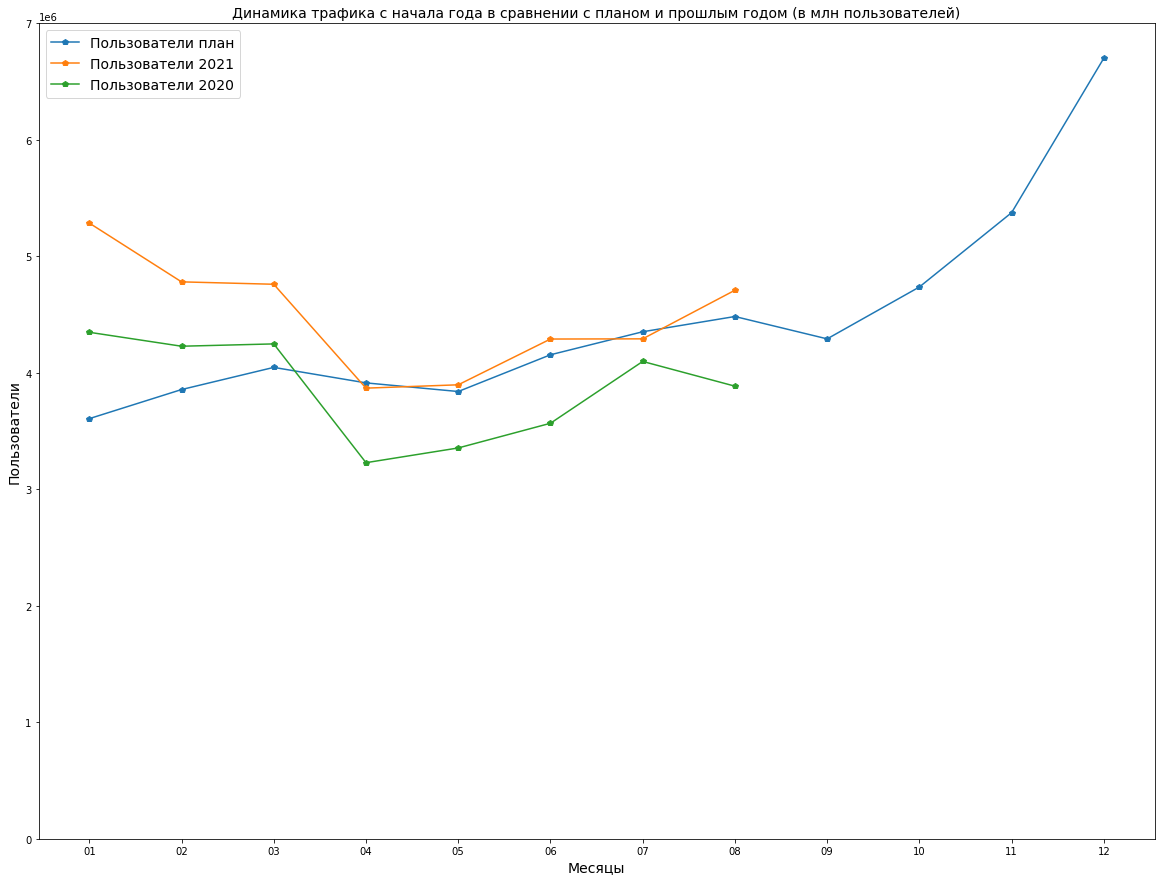

In [148]:
plt.figure(figsize=(20, 15))
plt.ylim([0, 7000000])
plt.plot(list(plan_df['month']), list(plan_df['users']), marker='p')
plt.plot(list(result_df_traff_month['month']), list(result_df_traff_month['users']), marker='p')
plt.plot(list(result_last_df_traff_month['month']), list(result_last_df_traff_month['users']), marker='p')
plt.title('Динамика трафика с начала года в сравнении с планом и прошлым годом (в млн пользователей)', fontsize=14)
plt.xlabel('Месяцы', fontsize=14)
plt.ylabel('Пользователи', fontsize=14)
# for item in result_df.itertuples(index=False):
#     arrowprops = {
#         'arrowstyle': '->',
#         'color': 'tab:orange'
#     }
#     plt.annotate(text='{0:,}'.format(item[2]).replace(',', ' '), 
#                  xy=(item[0], item[2]),
#                  xytext = (item[0], item[2]+500000),
#                  arrowprops = arrowprops,
#                  fontsize=14, 
#                  color='tab:orange')
plt.legend(['Пользователи план', 'Пользователи 2021', 'Пользователи 2020'], fontsize=14)
plt.show()

### Недельные данные по трафику
* В сравнении с прошлым годом

In [149]:
summary_data = result_df_traff_week.merge(result_last_df_traff_week, on='week', how='inner')
summary_data.rename(columns = {'week':'Неделя', 'users_x':'Пользователи 2021','users_y':'Пользователи 2020'}, inplace = True)
summary_data['Прирост к прошлому году %'] = (summary_data['Пользователи 2021']/summary_data['Пользователи 2020'])*100-100
summary_data.fillna(0, inplace = True)
summary_data.drop(['source_x', 'source_y'], axis = 1, inplace=True)

display(summary_data)

#del params['filters']


,Неделя,Пользователи 2021,Пользователи 2020,Прирост к прошлому году %
0,01,1477646.0,829221.0,78.196886
1,02,1372034.0,1202803.0,14.069719
2,03,1230721.0,1140146.0,7.944158
3,04,1321459.0,1108949.0,19.163190
4,05,1311604.0,1207784.0,8.595908
5,06,1253220.0,1112619.0,12.636940
6,07,1510185.0,1187598.0,27.162979
7,08,1414985.0,1188122.0,19.094251
8,09,1390813.0,1154565.0,20.462079
9,10,1227374.0,1200182.0,2.265656


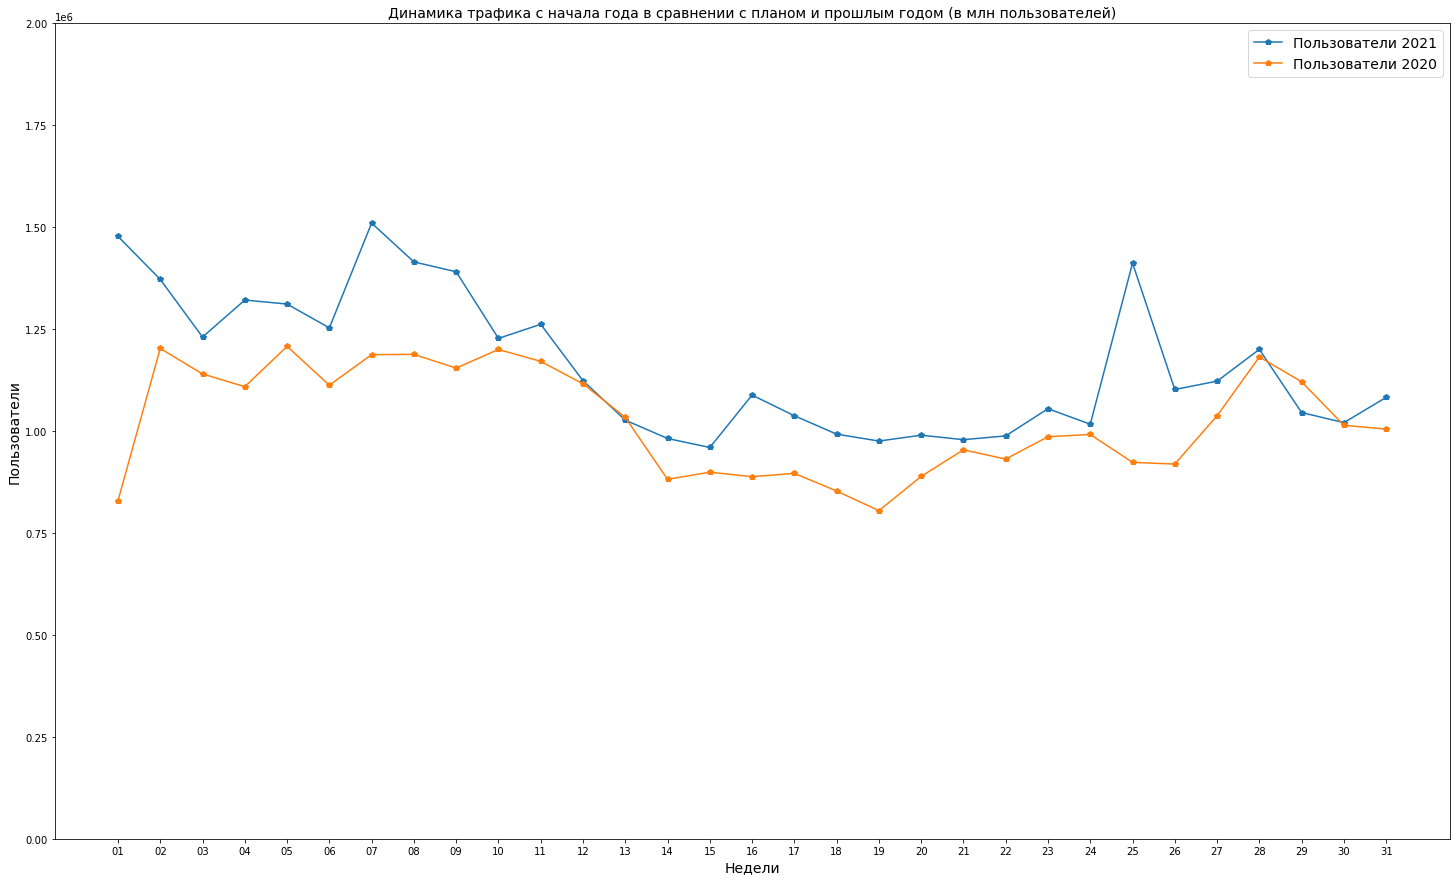

In [150]:
plt.figure(figsize=(25, 15))
plt.ylim([0, 2000000])
plt.plot(list(summary_data['Неделя']), list(summary_data['Пользователи 2021']), marker='p')
plt.plot(list(summary_data['Неделя']), list(summary_data['Пользователи 2020']), marker='p')
plt.title('Динамика трафика с начала года в сравнении с планом и прошлым годом (в млн пользователей)', fontsize=14)
plt.xlabel('Недели', fontsize=14)
plt.ylabel('Пользователи', fontsize=14)

# offset = len(list(result_df.itertuples(index=False)))%4
# step = 1

# for item in result_df.itertuples(index=False):
#     if step % 4 == offset:
#         arrowprops = {
#             'arrowstyle': '->',
#             'color': 'tab:blue'
#         }
#         plt.annotate(text='{0:,}'.format(item[2]).replace(',', ' '), 
#                      xy=(item[0], item[2]),
#                      xytext = (item[0], item[2]+50000),
#                      arrowprops = arrowprops,
#                      fontsize=16, 
#                      color='tab:blue')
#     step += 1
    
plt.legend(['Пользователи 2021', 'Пользователи 2020'], fontsize=14)
plt.show()

### Динамика оформленных заказов
* Сравнение с прошлым годом
* Выполнение плана<c/enter>

In [151]:
plan_df = pd.read_excel('План по SEO с продажами.xlsx', dtype={'Месяц': 'string', 'Оформленный оборот': 'float'})
plan_df.rename(columns = {'Месяц':'month'}, inplace=True)

summary_data = result_df_tran_month.merge(result_last_df_tran_month, on='month', how='outer').merge(plan_df, on='month', how='outer')
summary_data.rename(columns = {'month':'Месяц', 'Revenue_x':'Оформленные заказы 2021','Revenue_y':'Оформленные заказы 2020', 'Оформленный оборот':'Оформленные заказы план'}, inplace = True)
summary_data['Выполнение плана %'] = (summary_data['Оформленные заказы 2021']/summary_data['Оформленные заказы план'])*100
summary_data['Прирост к прошлому году %'] = (summary_data['Оформленные заказы 2021']/summary_data['Оформленные заказы 2020'])*100-100

summary_data.fillna(0, inplace = True)
summary_data.drop(['source_x', 'source_y'], axis = 1, inplace=True)

summary_data['Оформленные заказы 2021'] = summary_data['Оформленные заказы 2021'].apply(lambda x: '{:,}'.format(trunc(x)).replace(',', ' '))
summary_data['Оформленные заказы 2020'] = summary_data['Оформленные заказы 2020'].apply(lambda x: '{:,}'.format(trunc(x)).replace(',', ' '))
summary_data['Оформленные заказы план'] = summary_data['Оформленные заказы план'].apply(lambda x: '{:,}'.format(trunc(x)).replace(',', ' '))

display(summary_data)

,Месяц,Оформленные заказы 2021,Оформленные заказы 2020,Оформленные заказы план,Выполнение плана %,Прирост к прошлому году %
0,01,3 030 013 545,1 983 607 294,1 939 000 032,156.266812,52.752692
1,02,2 890 380 453,1 811 610 737,1 958 391 719,147.589495,59.547545
2,03,2 926 793 922,2 935 505 985,2 501 208 968,117.015170,-0.296782
3,04,2 395 564 729,2 841 533 502,1 859 782 699,128.808851,-15.694651
4,05,2 159 868 416,2 770 377 888,1 813 442 652,119.103210,-22.037047
5,06,2 343 092 923,2 606 195 618,2 238 589 864,104.668254,-10.095278
6,07,2 175 333 931,2 718 606 044,2 473 632 042,87.940886,-19.983481
7,08,1 467 754 822,2 650 101 970,2 466 779 632,59.500849,-44.615157
8,09,0,0,2 454 400 018,0.000000,0.000000
9,10,0,0,3 025 006 242,0.000000,0.000000


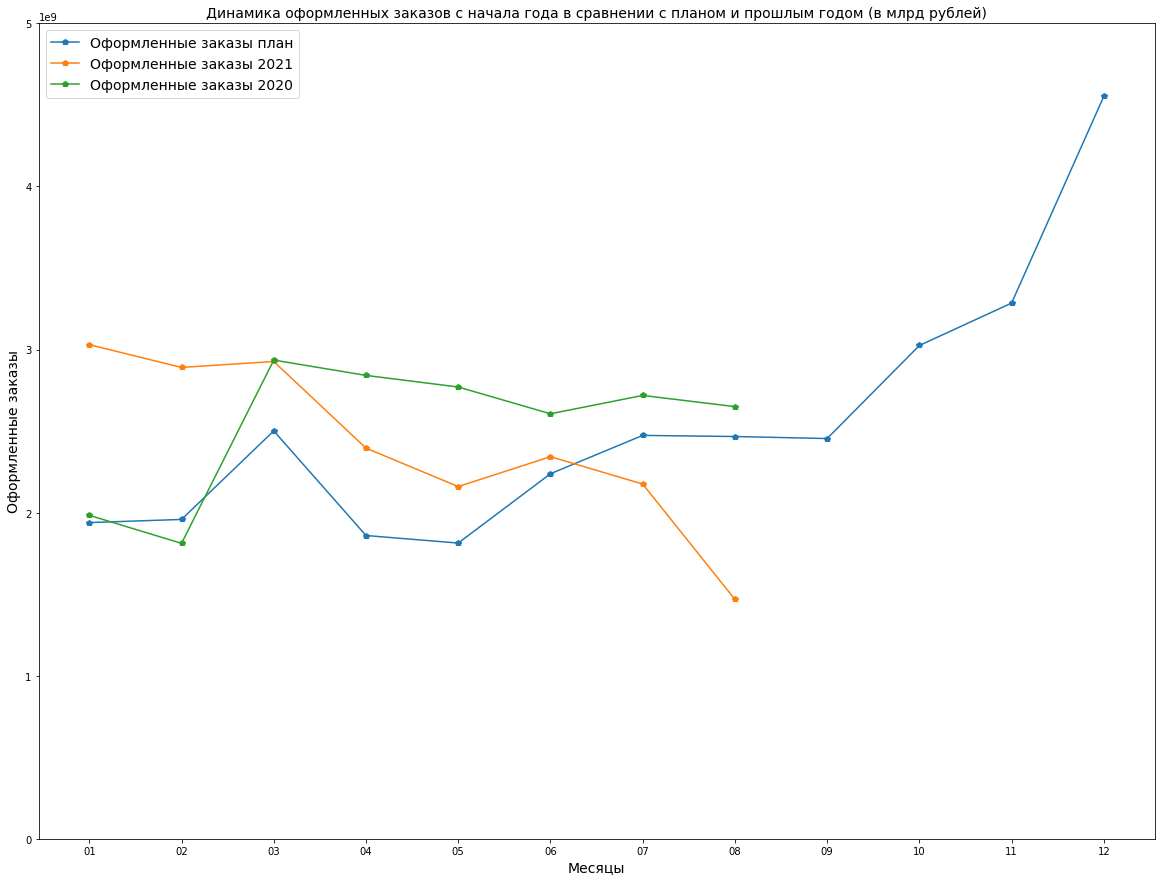

In [152]:
plt.figure(figsize=(20, 15))
plt.ylim([0, 5000000000])

plt.plot(list(plan_df['month']), list(plan_df['Оформленный оборот']), marker='p')
plt.plot(list(result_df_tran_month['month']), list(result_df_tran_month['Revenue']), marker='p')
plt.plot(list(result_last_df_tran_month['month']), list(result_last_df_tran_month['Revenue']), marker='p')
plt.title('Динамика оформленных заказов с начала года в сравнении с планом и прошлым годом (в млрд рублей)', fontsize=14)
plt.xlabel('Месяцы', fontsize=14)
plt.ylabel('Оформленные заказы', fontsize=14)
# for item in result_df.itertuples(index=False):
#     arrowprops = {
#         'arrowstyle': '->',
#         'color': 'tab:orange'
#     }
#     plt.annotate(text='{0:,}'.format(item[2]).replace(',', ' '), 
#                  xy=(item[0], item[2]),
#                  xytext = (item[0], item[2]+700000000),
#                  arrowprops = arrowprops,
#                  fontsize=14, 
#                  color='tab:orange')
plt.legend(['Оформленные заказы план', 'Оформленные заказы 2021', 'Оформленные заказы 2020'], fontsize=14)
plt.show()

### Динамика брендового трафика с начала года
* В сравнении с прошлым годом

In [153]:
brend_info = get_Ya_brend('2021-01-01', 'yesterday')
date = datetime.today()
date -= timedelta(days=365)
last_date = datetime.strftime(date, '%Y-%m-%d')
past_brend_info = get_Ya_brend('2020-01-01', last_date)

all_info = summary_data_org_traff.merge(brend_info, on='Месяц', how='inner').merge(past_brend_info, on='Месяц', how='inner')
brend_traff = all_info.loc[:, ['Месяц', 'Пользователи 2021', 'Пользователи 2020', 'path_brand_x', 'path_brand_y']]
brend_traff['Пользователи 2021'] = brend_traff['Пользователи 2021'].apply(lambda x: x.replace(' ', '')).astype('float64')
brend_traff['Пользователи 2020'] = brend_traff['Пользователи 2020'].apply(lambda x: x.replace(' ', '')).astype('float64')

brend_traff['Брендовый трафик 2021'] = round(brend_traff['Пользователи 2021']*brend_traff['path_brand_x'])
brend_traff['Брендовый трафик 2020'] = round(brend_traff['Пользователи 2020']*brend_traff['path_brand_y'])
brend_traff['Прирост к прошлому году %'] = (brend_traff['Брендовый трафик 2021']/brend_traff['Брендовый трафик 2020'])*100 - 100

brend_traff_correct = brend_traff.copy()
brend_traff_correct['Брендовый трафик 2021'] = brend_traff_correct['Брендовый трафик 2021'].apply(lambda x: '{:,}'.format(trunc(x)).replace(',', ' '))
brend_traff_correct['Брендовый трафик 2020'] = brend_traff_correct['Брендовый трафик 2020'].apply(lambda x: '{:,}'.format(trunc(x)).replace(',', ' '))

display(brend_traff_correct.loc[:, ['Месяц','Брендовый трафик 2021', 'Брендовый трафик 2020', 'Прирост к прошлому году %']])


,Месяц,Брендовый трафик 2021,Брендовый трафик 2020,Прирост к прошлому году %
0,01,1 512 862,1 383 188,9.375009
1,02,1 444 754,1 356 639,6.495096
2,03,1 280 250,1 320 782,-3.068788
3,04,1 022 666,1 110 489,-7.908498
4,05,1 081 995,966 006,12.007068
5,06,1 180 381,1 068 829,10.436843
6,07,1 002 637,1 392 805,-28.013110
7,08,1 297 853,1 360 891,-4.632112


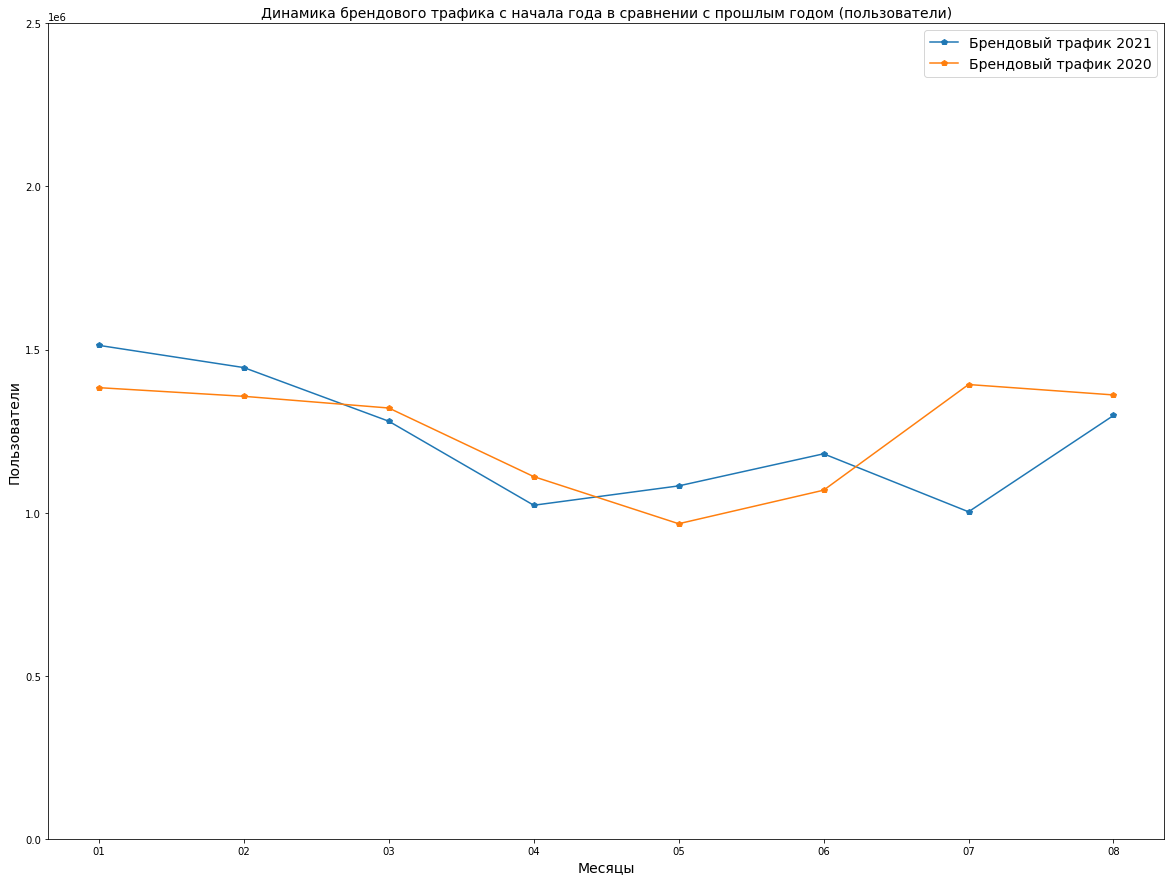

In [154]:
plt.figure(figsize=(20, 15))
plt.ylim([0, 2500000])
plt.plot(brend_traff['Месяц'], brend_traff['Брендовый трафик 2021'], marker='p')
plt.plot(brend_traff['Месяц'], brend_traff['Брендовый трафик 2020'], marker='p')
plt.title('Динамика брендового трафика с начала года в сравнении с прошлым годом (пользователи)', fontsize=14)
plt.xlabel('Месяцы', fontsize=14)
plt.ylabel('Пользователи', fontsize=14)
# for item in brend_traff.itertuples(index=False):
#     arrowprops = {
#         'arrowstyle': '->',
#         'color': 'tab:blue'
#     }
#     plt.annotate(text='{0:,}'.format(item[5]).replace(',', ' '), 
#                  xy=(item[0], item[5]),
#                  xytext = (item[0], item[5]+70000),
#                  arrowprops = arrowprops,
#                  fontsize=14, 
#                  color='tab:blue')
plt.legend(['Брендовый трафик 2021', 'Брендовый трафик 2020'], fontsize=14)
plt.show()

### Динамика небрендового трафика с начала года
* В сравнении с прошлым годом

In [155]:
all_info
nobrand_traff = all_info.loc[:, ['Месяц', 'Пользователи 2021', 'Пользователи 2020', 'path_nobrand_x', 'path_nobrand_y']]
nobrand_traff['Пользователи 2021'] = nobrand_traff['Пользователи 2021'].apply(lambda x: x.replace(' ', '')).astype('float64')
nobrand_traff['Пользователи 2020'] = nobrand_traff['Пользователи 2020'].apply(lambda x: x.replace(' ', '')).astype('float64')

nobrand_traff['Небрендовый трафик 2021'] = round(nobrand_traff['Пользователи 2021']*nobrand_traff['path_nobrand_x'])
nobrand_traff['Небрендовый трафик 2020'] = round(nobrand_traff['Пользователи 2020']*nobrand_traff['path_nobrand_y'])
nobrand_traff['Прирост к прошлому году %'] = (nobrand_traff['Небрендовый трафик 2021']/nobrand_traff['Небрендовый трафик 2020'])*100 - 100

nobrand_traff_correct = nobrand_traff.copy()

nobrand_traff_correct['Небрендовый трафик 2021'] = nobrand_traff_correct['Небрендовый трафик 2021'].apply(lambda x: '{:,}'.format(trunc(x)).replace(',', ' '))
nobrand_traff_correct['Небрендовый трафик 2020'] = nobrand_traff_correct['Небрендовый трафик 2020'].apply(lambda x: '{:,}'.format(trunc(x)).replace(',', ' '))

display(nobrand_traff_correct.loc[:, ['Месяц','Небрендовый трафик 2021', 'Небрендовый трафик 2020', 'Прирост к прошлому году %']])


,Месяц,Небрендовый трафик 2021,Небрендовый трафик 2020,Прирост к прошлому году %
0,01,3 772 973,2 965 075,27.247135
1,02,3 336 446,2 871 949,16.173581
2,03,3 480 311,2 927 801,18.871160
3,04,2 846 138,2 118 364,34.355474
4,05,2 815 444,2 389 284,17.836306
5,06,3 109 944,2 498 464,24.474237
6,07,3 289 361,2 705 230,21.592656
7,08,3 411 388,2 524 847,35.112662


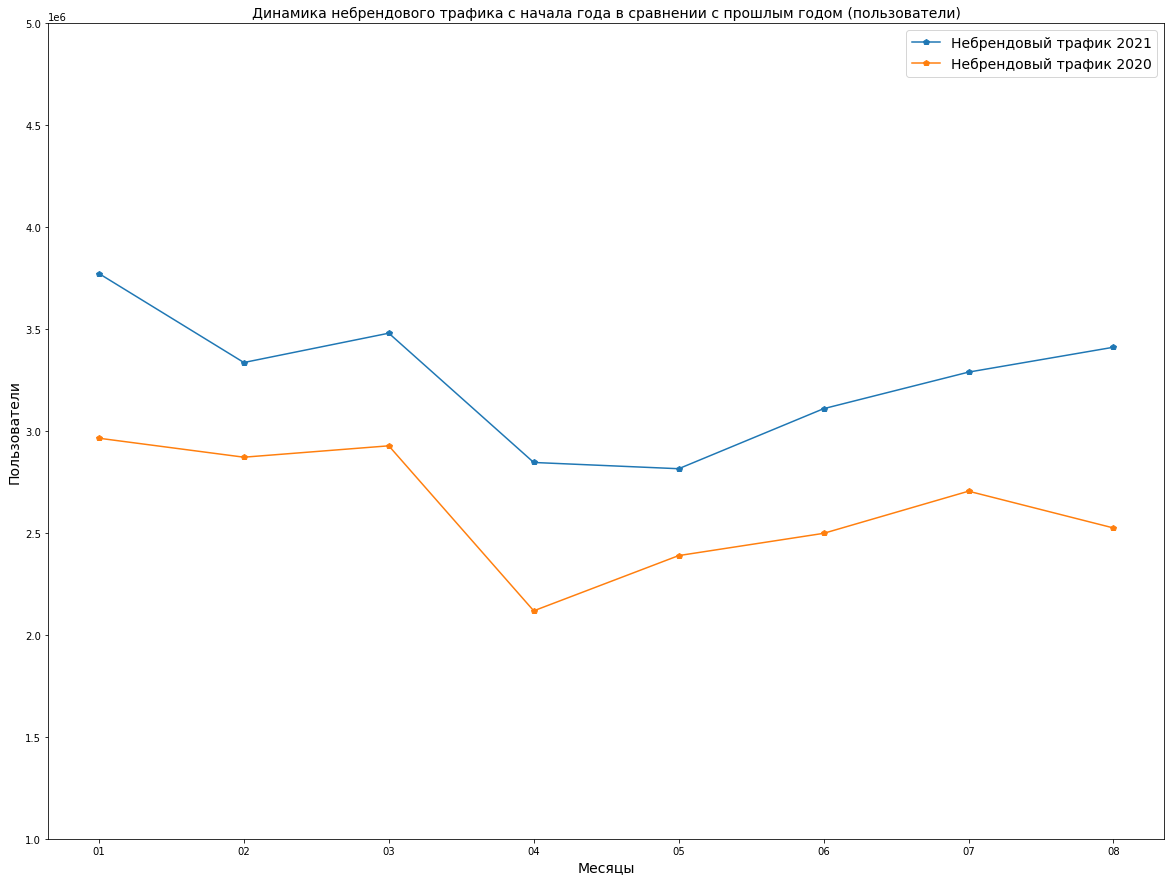

In [156]:
plt.figure(figsize=(20, 15))
plt.ylim([1000000, 5000000])

plt.plot(nobrand_traff['Месяц'], nobrand_traff['Небрендовый трафик 2021'], marker='p')
plt.plot(nobrand_traff['Месяц'], nobrand_traff['Небрендовый трафик 2020'], marker='p')
plt.title('Динамика небрендового трафика с начала года в сравнении с прошлым годом (пользователи)', fontsize=14)
plt.xlabel('Месяцы', fontsize=14)
plt.ylabel('Пользователи', fontsize=14)
# for item in nobrand_traff.itertuples(index=False):
#     arrowprops = {
#         'arrowstyle': '->',
#         'color': 'tab:blue'
#     }
#     plt.annotate(text='{0:,}'.format(item[5]).replace(',', ' '), 
#                  xy=(item[0], item[5]),
#                  xytext = (item[0], item[5]+120000),
#                  arrowprops = arrowprops,
#                  fontsize=14, 
#                  color='tab:blue')
plt.legend(['Небрендовый трафик 2021', 'Небрендовый трафик 2020'], fontsize=14)
plt.show()


### Динамика трафика из поисковой системы Яндекс
* В сравнении с прошлым годом

In [157]:
summary_data = result_df_ya_traff.merge(result_last_df_ya_traff, on='month', how='outer')
summary_data.rename(columns = {'month':'Месяц', 'users_x':'Пользователи 2021','users_y':'Пользователи 2020', 'users':'Пользователи план'}, inplace = True)
summary_data['Прирост к прошлому году %'] = (summary_data['Пользователи 2021']/summary_data['Пользователи 2020'])*100-100
summary_data.fillna(0, inplace = True)
summary_data.drop(['source_x', 'source_y', 'source_type_x', 'source_type_y'], axis = 1, inplace=True)
summary_data['Пользователи 2021'] = summary_data['Пользователи 2021'].apply(lambda x: '{:,}'.format(trunc(x)).replace(',', ' '))
summary_data['Пользователи 2020'] = summary_data['Пользователи 2020'].apply(lambda x: '{:,}'.format(trunc(x)).replace(',', ' '))

display(summary_data)


,Месяц,Пользователи 2021,Пользователи 2020,Прирост к прошлому году %
0,01,2 592 900,2 489 813,4.140351
1,02,2 339 095,2 318 138,0.904045
2,03,2 372 564,2 366 927,0.238157
3,04,1 854 542,1 823 202,1.718954
4,05,1 847 476,1 886 602,-2.073887
5,06,2 036 761,1 865 468,9.182307
6,07,2 031 926,2 131 069,-4.652266
7,08,566 366,553 640,2.298606


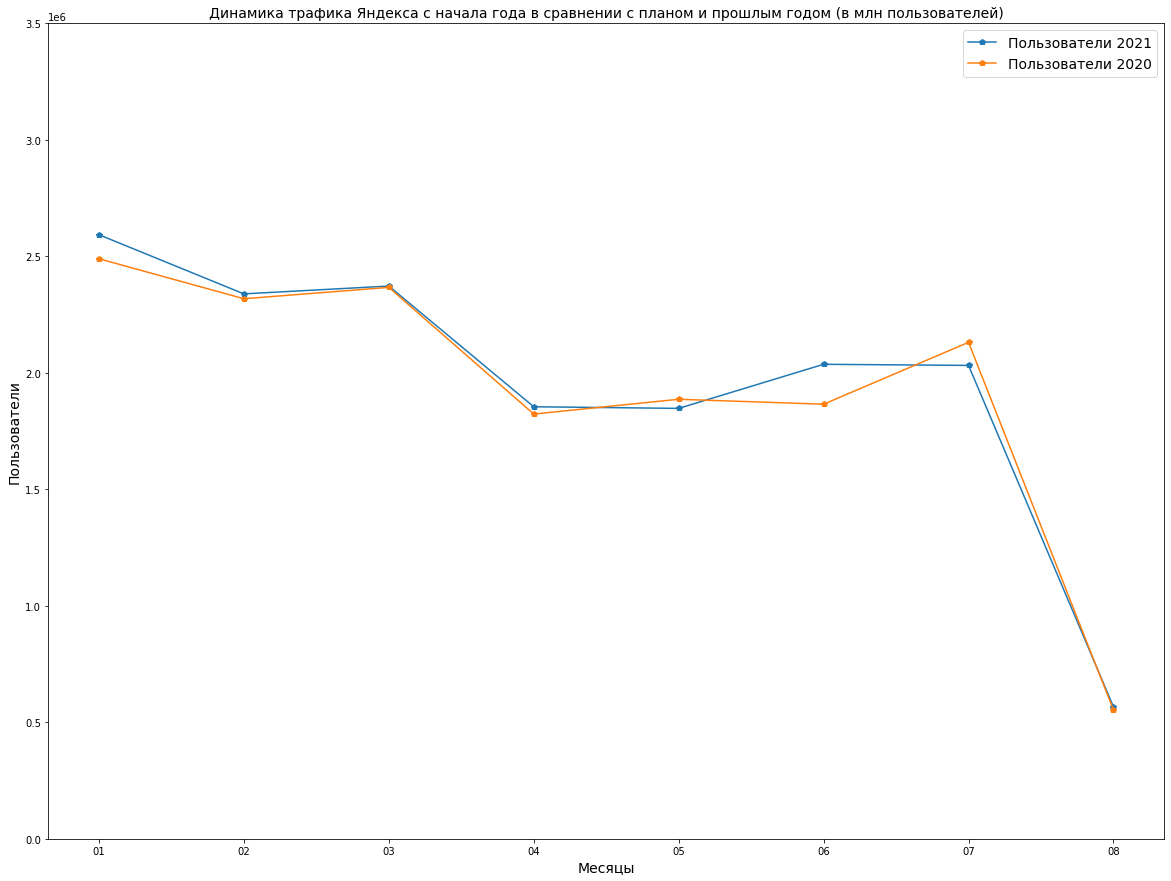

In [158]:
plt.figure(figsize=(20, 15))
plt.ylim([0, 3500000])
plt.plot(list(result_df_ya_traff['month']), list(result_df_ya_traff['users']), marker='p')
plt.plot(list(result_last_df_ya_traff['month']), list(result_last_df_ya_traff['users']), marker='p')
plt.title('Динамика трафика Яндекса с начала года в сравнении с планом и прошлым годом (в млн пользователей)', fontsize=14)
plt.xlabel('Месяцы', fontsize=14)
plt.ylabel('Пользователи', fontsize=14)
# for item in result_df_ya_traff.itertuples(index=False):
#     arrowprops = {
#         'arrowstyle': '->',
#         'color': 'tab:blue'
#     }
#     plt.annotate(text='{0:,}'.format(item[3]).replace(',', ' '), 
#                  xy=(item[0], item[3]),
#                  xytext = (item[0], item[3]+300000),
#                  arrowprops = arrowprops,
#                  fontsize=14, 
#                  color='tab:blue')
plt.legend(['Пользователи 2021', 'Пользователи 2020'], fontsize=14)
plt.show()

### Динамика трафика из поисковой системы Google
* В сравнении с прошлым годом

In [159]:
summary_data = result_df_ggl_traff.merge(result_last_df_ggl_traff, on='month', how='outer')
summary_data.rename(columns = {'month':'Месяц', 'users_x':'Пользователи 2021','users_y':'Пользователи 2020', 'users':'Пользователи план'}, inplace = True)
summary_data['Прирост к прошлому году %'] = (summary_data['Пользователи 2021']/summary_data['Пользователи 2020'])*100-100
summary_data.fillna(0, inplace = True)
summary_data.drop(['source_x', 'source_y', 'source_type_x', 'source_type_y'], axis = 1, inplace=True)
summary_data['Пользователи 2021'] = summary_data['Пользователи 2021'].apply(lambda x: '{:,}'.format(trunc(x)).replace(',', ' '))
summary_data['Пользователи 2020'] = summary_data['Пользователи 2020'].apply(lambda x: '{:,}'.format(trunc(x)).replace(',', ' '))

display(summary_data)

,Месяц,Пользователи 2021,Пользователи 2020,Прирост к прошлому году %
0,01,2 636 968,1 791 893,47.161019
1,02,2 363 081,1 800 242,31.264630
2,03,2 305 999,1 766 064,30.572788
3,04,1 916 831,1 398 710,37.042775
4,05,1 968 150,1 428 975,37.731591
5,06,2 165 616,1 642 395,31.857196
6,07,2 138 469,1 905 909,12.202052
7,08,610 061,534 855,14.061007


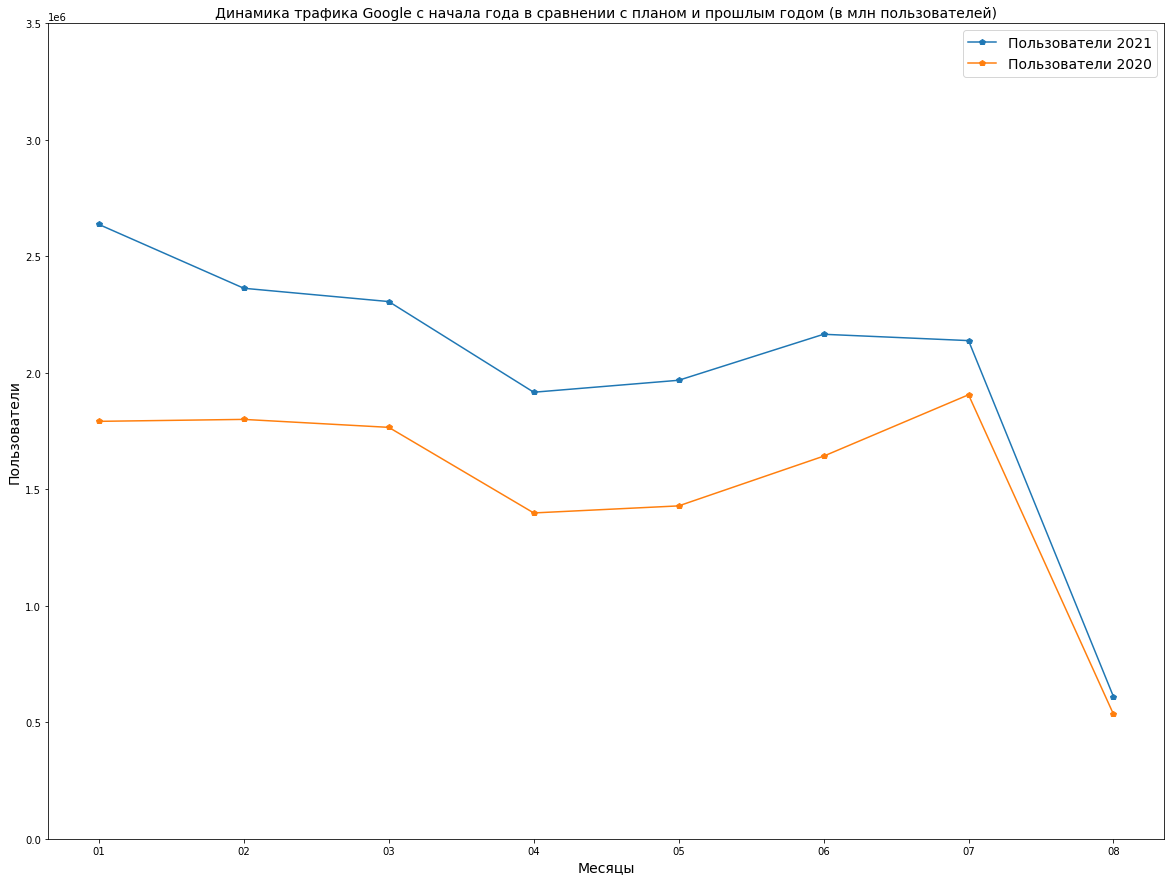

In [160]:
plt.figure(figsize=(20, 15))
plt.ylim([0, 3500000])
plt.plot(list(result_df_ggl_traff['month']), list(result_df_ggl_traff['users']), marker='p')
plt.plot(list(result_last_df_ggl_traff['month']), list(result_last_df_ggl_traff['users']), marker='p')
plt.title('Динамика трафика Google с начала года в сравнении с планом и прошлым годом (в млн пользователей)', fontsize=14)
plt.xlabel('Месяцы', fontsize=14)
plt.ylabel('Пользователи', fontsize=14)
# for item in result_df.itertuples(index=False):
#     arrowprops = {
#         'arrowstyle': '->',
#         'color': 'tab:blue'
#     }
#     plt.annotate(text='{0:,}'.format(item[3]).replace(',', ' '), 
#                  xy=(item[0], item[3]),
#                  xytext = (item[0], item[3]+300000),
#                  arrowprops = arrowprops,
#                  fontsize=14, 
#                  color='tab:blue')
plt.legend(['Пользователи 2021', 'Пользователи 2020'], fontsize=14)
plt.show()

### Отчет по видимости Яндекс

In [161]:
display(df_vision)

,Дата,% в топ 3,% в топ 5,% в топ 10,"%""WS""10",% P Traf
14,2021-07-11,17.41,32.95,56.30,44.44,15.70
13,2021-07-13,16.66,32.28,55.99,44.41,15.72
12,2021-07-15,16.54,32.16,55.87,44.81,15.74
11,2021-07-17,11.47,27.51,53.10,43.76,14.57
10,2021-07-19,10.46,26.21,51.89,41.77,13.99
9,2021-07-21,10.32,26.01,52.01,41.38,13.77
8,2021-07-23,10.86,26.64,52.76,41.71,13.92
7,2021-07-25,10.74,26.53,53.12,46.41,15.10
6,2021-07-27,10.54,27.33,53.46,48.66,15.45
5,2021-07-29,9.40,24.17,51.51,46.03,14.81


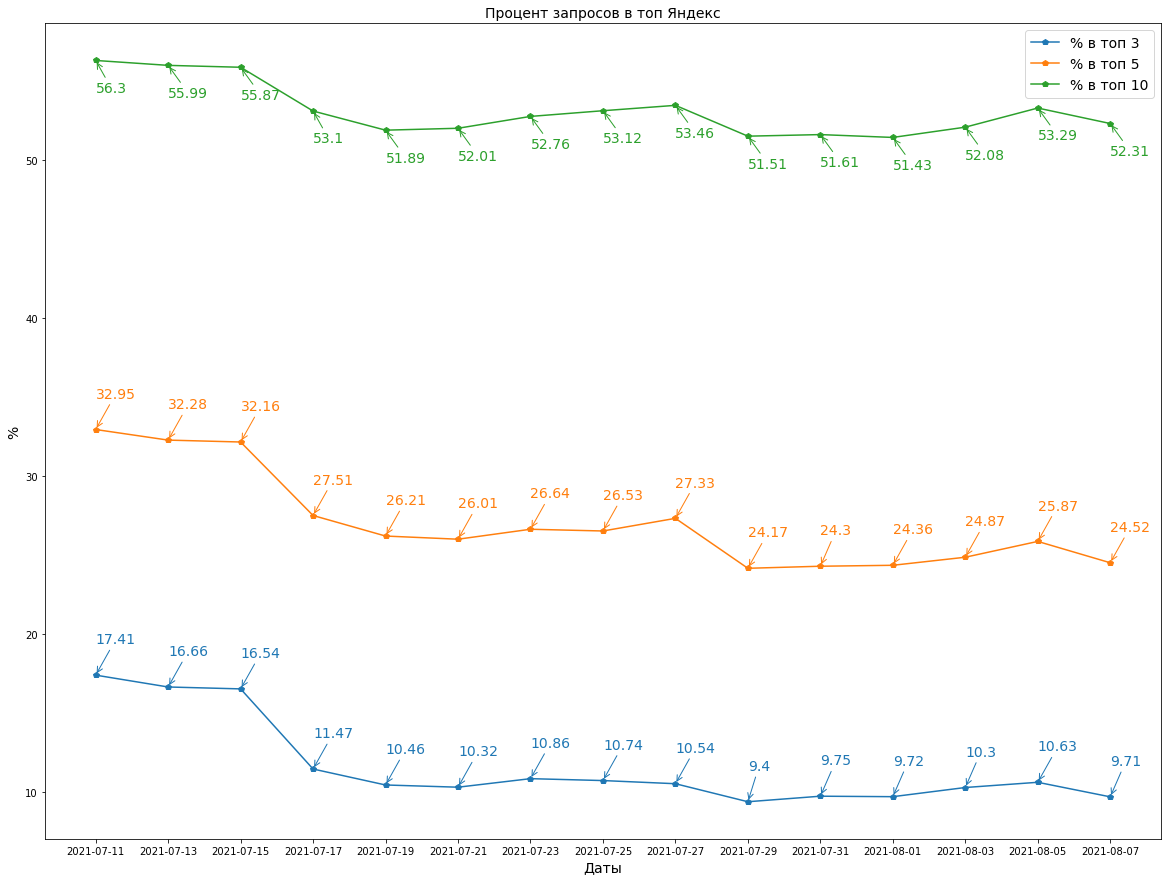

In [162]:
plt.figure(figsize=(20, 15))
plt.plot(df_vision['Дата'], df_vision['% в топ 3'], marker='p')
plt.plot(df_vision['Дата'], df_vision['% в топ 5'], marker='p')
plt.plot(df_vision['Дата'], df_vision['% в топ 10'], marker='p')
plt.title('Процент запросов в топ Яндекс', fontsize=14)
plt.xlabel('Даты', fontsize=14)
plt.ylabel('%', fontsize=14)

for item in df_vision.itertuples(index=False):
    arrowprops = {
        'arrowstyle': '->',
        'color': 'tab:blue'
    }
    plt.annotate(text=str(item[1]), 
                 xy=(item[0], item[1]),
                 xytext = (item[0], item[1]+2),
                 arrowprops = arrowprops,
                 fontsize=14, 
                 color='tab:blue')
    
    arrowprops = {
        'arrowstyle': '->',
        'color': 'tab:orange'
    }
    
    plt.annotate(text=str(item[2]), 
                 xy=(item[0], item[2]),
                 xytext = (item[0], item[2]+2),
                 arrowprops = arrowprops,
                 fontsize=14, 
                 color='tab:orange')
    
    arrowprops = {
        'arrowstyle': '->',
        'color': 'tab:green'
    }
    
    plt.annotate(text=str(item[3]), 
                 xy=(item[0], item[3]),
                 xytext = (item[0], item[3]-2),
                 arrowprops = arrowprops,
                 fontsize=14, 
                 color='tab:green')

plt.legend(['% в топ 3', '% в топ 5', '% в топ 10'], fontsize=14)
plt.show()

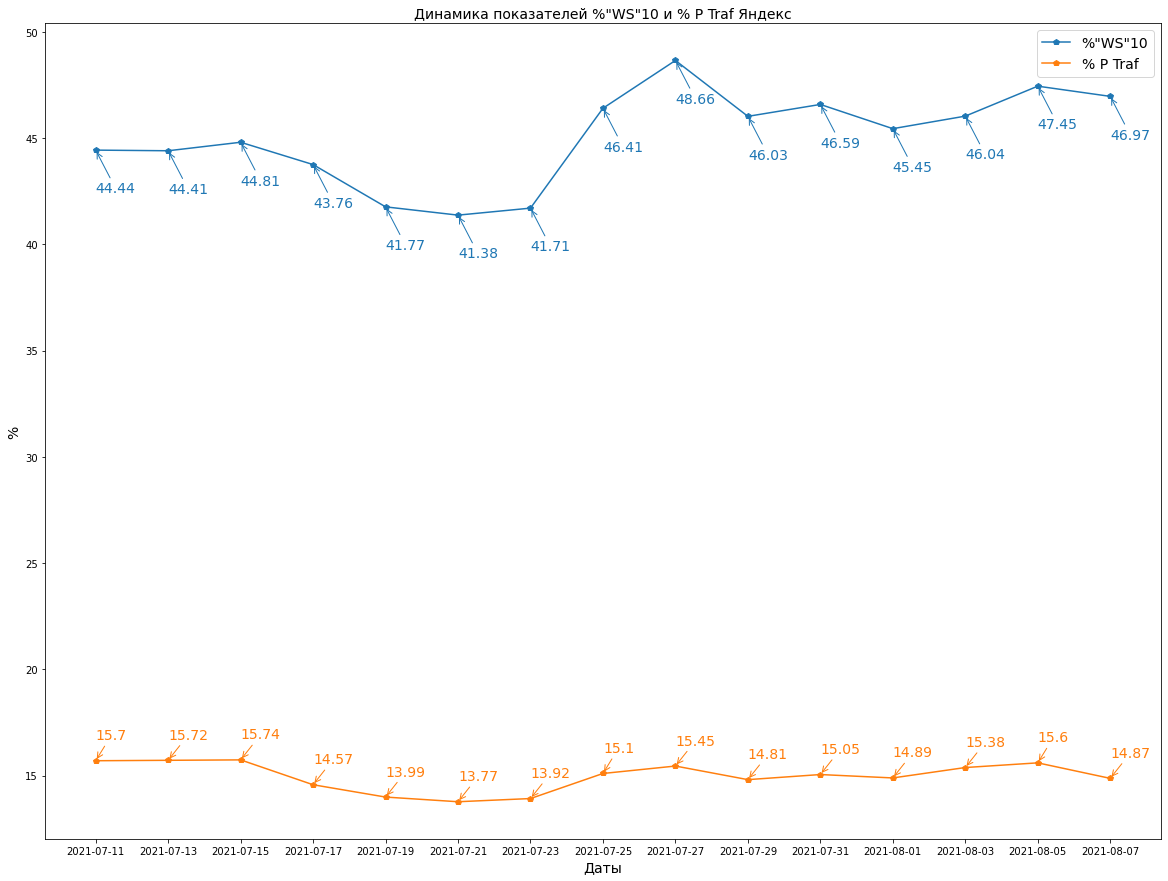

In [163]:
plt.figure(figsize=(20, 15))
plt.plot(df_vision['Дата'], df_vision['%"WS"10'], marker='p')
plt.plot(df_vision['Дата'], df_vision['% P Traf'], marker='p')
plt.title('Динамика показателей %"WS"10 и % P Traf Яндекс', fontsize=14)
plt.xlabel('Даты', fontsize=14)
plt.ylabel('%', fontsize=14)

for item in df_vision.itertuples(index=False):
    arrowprops = {
        'arrowstyle': '->',
        'color': 'tab:blue'
    }
    plt.annotate(text=str(item[4]), 
                 xy=(item[0], item[4]),
                 xytext = (item[0], item[4]-2),
                 arrowprops = arrowprops,
                 fontsize=14, 
                 color='tab:blue')
    
    arrowprops = {
        'arrowstyle': '->',
        'color': 'tab:orange'
    }
    
    plt.annotate(text=str(item[5]), 
                 xy=(item[0], item[5]),
                 xytext = (item[0], item[5]+1),
                 arrowprops = arrowprops,
                 fontsize=14, 
                 color='tab:orange')

plt.legend(['%"WS"10', '% P Traf'], fontsize=14)
plt.show()

### Отчет по видимости Google

In [164]:
display(df_vis_ggl)

,Дата,% в топ 3,% в топ 5,% в топ 10,"%""WS""10",% P Traf
15,2021-07-11,27.46,42.62,63.66,61.47,27.52
14,2021-07-13,28.34,43.61,64.41,60.91,28.27
13,2021-07-15,27.87,43.34,64.47,60.72,27.86
12,2021-07-17,28.38,43.76,64.76,60.95,28.40
11,2021-07-19,28.36,43.54,64.51,62.45,28.65
10,2021-07-21,28.64,43.69,64.54,61.25,28.63
9,2021-07-23,28.65,43.66,64.56,61.66,28.60
8,2021-07-25,28.70,43.79,64.67,64.82,31.86
7,2021-07-27,28.74,43.99,64.94,66.16,33.18
6,2021-07-29,28.25,43.46,64.57,67.37,33.00


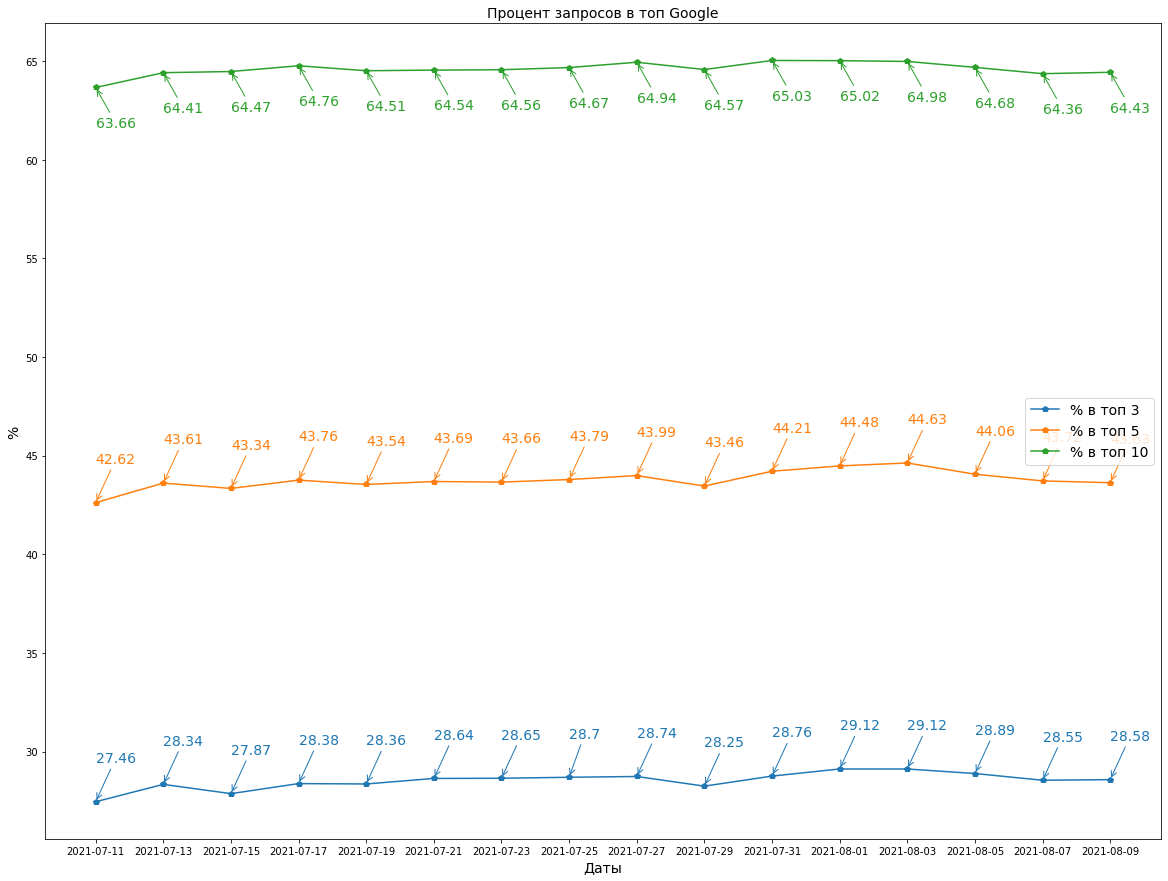

In [165]:
plt.figure(figsize=(20, 15))
plt.plot(df_vis_ggl['Дата'], df_vis_ggl['% в топ 3'], marker='p')
plt.plot(df_vis_ggl['Дата'], df_vis_ggl['% в топ 5'], marker='p')
plt.plot(df_vis_ggl['Дата'], df_vis_ggl['% в топ 10'], marker='p')
plt.title('Процент запросов в топ Google', fontsize=14)
plt.xlabel('Даты', fontsize=14)
plt.ylabel('%', fontsize=14)

for item in df_vis_ggl.itertuples(index=False):
    arrowprops = {
        'arrowstyle': '->',
        'color': 'tab:blue'
    }
    plt.annotate(text=str(item[1]), 
                 xy=(item[0], item[1]),
                 xytext = (item[0], item[1]+2),
                 arrowprops = arrowprops,
                 fontsize=14, 
                 color='tab:blue')
    
    arrowprops = {
        'arrowstyle': '->',
        'color': 'tab:orange'
    }
    
    plt.annotate(text=str(item[2]), 
                 xy=(item[0], item[2]),
                 xytext = (item[0], item[2]+2),
                 arrowprops = arrowprops,
                 fontsize=14, 
                 color='tab:orange')
    
    arrowprops = {
        'arrowstyle': '->',
        'color': 'tab:green'
    }
    
    plt.annotate(text=str(item[3]), 
                 xy=(item[0], item[3]),
                 xytext = (item[0], item[3]-2),
                 arrowprops = arrowprops,
                 fontsize=14, 
                 color='tab:green')

plt.legend(['% в топ 3', '% в топ 5', '% в топ 10'], fontsize=14)
plt.show()

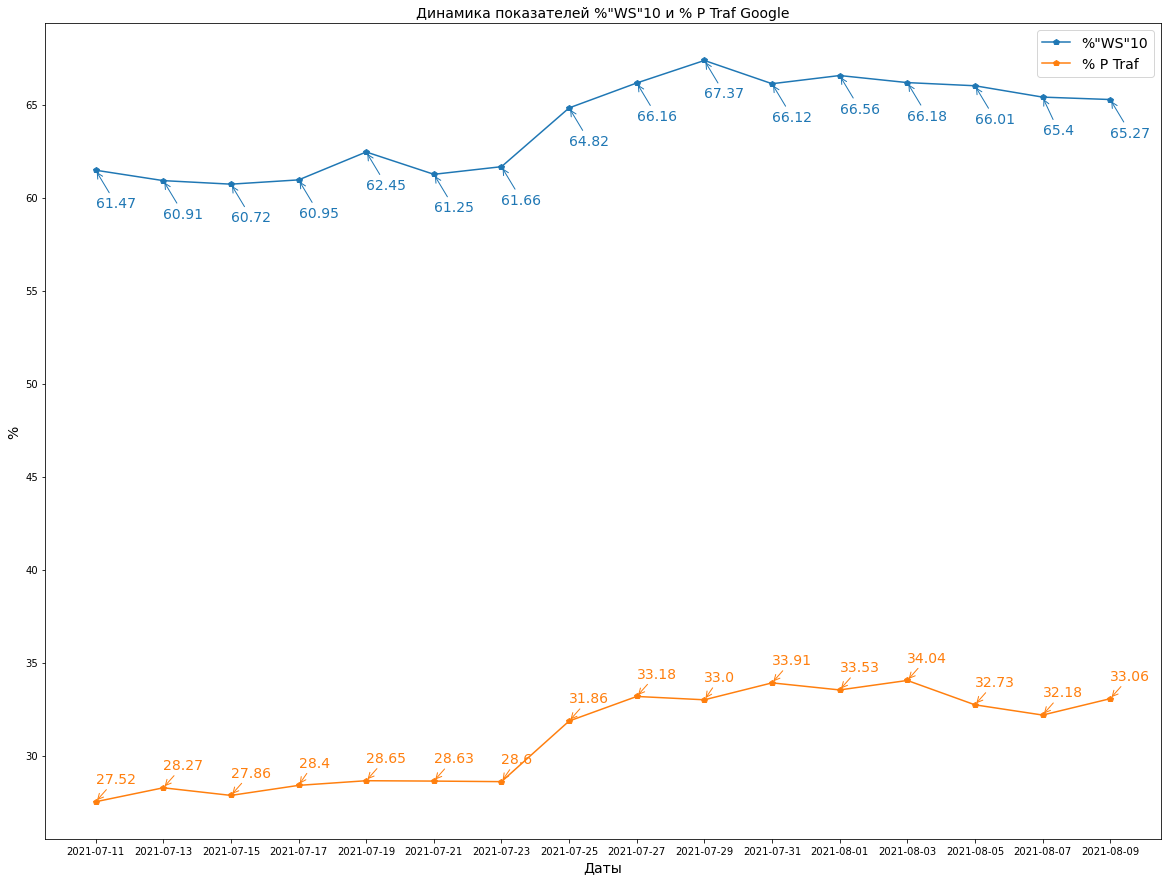

In [166]:
plt.figure(figsize=(20, 15))
plt.plot(df_vis_ggl['Дата'], df_vis_ggl['%"WS"10'], marker='p')
plt.plot(df_vis_ggl['Дата'], df_vis_ggl['% P Traf'], marker='p')
plt.title('Динамика показателей %"WS"10 и % P Traf Google', fontsize=14)
plt.xlabel('Даты', fontsize=14)
plt.ylabel('%', fontsize=14)

for item in df_vis_ggl.itertuples(index=False):
    arrowprops = {
        'arrowstyle': '->',
        'color': 'tab:blue'
    }
    plt.annotate(text=str(item[4]), 
                 xy=(item[0], item[4]),
                 xytext = (item[0], item[4]-2),
                 arrowprops = arrowprops,
                 fontsize=14, 
                 color='tab:blue')
    
    arrowprops = {
        'arrowstyle': '->',
        'color': 'tab:orange'
    }
    
    plt.annotate(text=str(item[5]), 
                 xy=(item[0], item[5]),
                 xytext = (item[0], item[5]+1),
                 arrowprops = arrowprops,
                 fontsize=14, 
                 color='tab:orange')

plt.legend(['%"WS"10', '% P Traf'], fontsize=14)
plt.show()

### Конкуренты в Яндекс

In [167]:
from IPython.display import display_html

_url_ = 'https://seowork.ru/competitors/api/v1/project/'

project_id = '328'
date_start = datetime.today()
date_to = datetime.strftime(date_start, '%Y-%m-%d')
date_start -= timedelta(days=30)
date_from = datetime.strftime(date_start, '%Y-%m-%d')

seo_params = {
    'token': '8406691e3decc16f97c941d5ac82ea7c',
    'limit': 10,
    'date_from': date_from,
    'date_to': date_to,
    'search_engine': 'yandex',
    'top': 10   
}

response = requests.get(_url_+project_id, params=seo_params)

host = []
top10_prc = []
ws2_top10_prc = []
p_traf_prc = []

for item in response.json()['data']['items']:
    host.append(item['host'])
    top10_prc.append(item['count_%'])
    ws2_top10_prc.append(item['ws2_%'])
    p_traf_prc.append(item['ptraf_%'])
    
seo_data = {
    'Конкурент': host,
    '% в топ 10': top10_prc,
    '%"WS"10': ws2_top10_prc,
    '% P Traf': p_traf_prc
}

df = pd.DataFrame(seo_data)

df_top10prc = df.loc[:, ['Конкурент', '% в топ 10']].sort_values(by='% в топ 10', ascending=False)
df_ws10prc = df.loc[:, ['Конкурент', '%"WS"10']].sort_values(by='%"WS"10', ascending=False)
ptraf = df.loc[:, ['Конкурент', '% P Traf']].sort_values(by='% P Traf', ascending=False)

df_top10prc.reset_index(inplace = True, drop = True)
df_ws10prc.reset_index(inplace = True, drop = True)
ptraf.reset_index(inplace = True, drop = True)

df1_styler = df_top10prc.style.set_table_attributes("style='display:inline'").set_caption('Топ 10 конкурентов по % в топ 10')
df2_styler = df_ws10prc.style.set_table_attributes("style='display:inline'").set_caption('Топ 10 конкурентов по %"WS"10')
df2_t_styler = ptraf.style.set_table_attributes("style='display:inline'").set_caption('Топ 10 конкурентов по % P Traf')

space = "\xa0" * 10
display_html(df1_styler._repr_html_()+space+df2_styler._repr_html_()+space+df2_t_styler._repr_html_(), raw=True)


,Конкурент,% в топ 10
0,market.yandex.ru,103.510000
1,e-katalog.ru,76.930000
2,mvideo.ru,64.580000
3,eldorado.ru,54.170000
4,ozon.ru,52.210000
5,dns-shop.ru,47.150000
6,citilink.ru,45.290000
7,sbermegamarket.ru,24.070000
8,wildberries.ru,19.430000
9,svyaznoy.ru,14.810000


### Конкуренты в Google

In [168]:
_url_ = 'https://seowork.ru/competitors/api/v1/project/'

project_id = '328'
date_start = datetime.today()
date_to = datetime.strftime(date_start, '%Y-%m-%d')
date_start -= timedelta(days=30)
date_from = datetime.strftime(date_start, '%Y-%m-%d')

seo_params = {
    'token': '8406691e3decc16f97c941d5ac82ea7c',
    'limit': 10,
    'date_from': date_from,
    'date_to': date_to,
    'search_engine': 'google',
    'top': 10   
}

response = requests.get(_url_+project_id, params=seo_params)

host = []
top10_prc = []
ws2_top10_prc = []
p_traf_prc = []

for item in response.json()['data']['items']:
    host.append(item['host'])
    top10_prc.append(item['count_%'])
    ws2_top10_prc.append(item['ws2_%'])
    p_traf_prc.append(item['ptraf_%'])
    
seo_data = {
    'Конкурент': host,
    '% в топ 10': top10_prc,
    '%"WS"10': ws2_top10_prc,
    '% P Traf': p_traf_prc
}

df = pd.DataFrame(seo_data)

df_top10prc = df.loc[:, ['Конкурент', '% в топ 10']].sort_values(by='% в топ 10', ascending=False)
df_ws10prc = df.loc[:, ['Конкурент', '%"WS"10']].sort_values(by='%"WS"10', ascending=False)
ptraf = df.loc[:, ['Конкурент', '% P Traf']].sort_values(by='% P Traf', ascending=False)

df_top10prc.reset_index(inplace = True, drop = True)
df_ws10prc.reset_index(inplace = True, drop = True)
ptraf.reset_index(inplace = True, drop = True)

df1_styler = df_top10prc.style.set_table_attributes("style='display:inline'").set_caption('Топ 10 конкурентов по % в топ 10')
df2_styler = df_ws10prc.style.set_table_attributes("style='display:inline'").set_caption('Топ 10 конкурентов по %"WS"10')
df2_t_styler = ptraf.style.set_table_attributes("style='display:inline'").set_caption('Топ 10 конкурентов по % P Traf')

space = "\xa0" * 10
display_html(df1_styler._repr_html_()+space+df2_styler._repr_html_()+space+df2_t_styler._repr_html_(), raw=True)


,Конкурент,% в топ 10
0,market.yandex.ru,91.240000
1,eldorado.ru,74.520000
2,mvideo.ru,72.450000
3,ozon.ru,68.900000
4,dns-shop.ru,57.120000
5,citilink.ru,29.950000
6,e-katalog.ru,29.640000
7,svyaznoy.ru,25.160000
8,avito.ru,14.890000
9,technopark.ru,11.090000


In [169]:
# Получение проседающих разделов

start_date = datetime.strftime(datetime.today() - timedelta(days=183), '%Y-%m-%d')
ya_param = {}
ya_param['date1'] = start_date
ya_param['date2'] = 'yesterday'
ya_param['id'] = 1937671
ya_param['metrics'] = 'ym:s:visits'
ya_param['filters'] = "ym:s:lastsignTrafficSource=='organic'"
ya_param['dimensions'] = 'ym:s:startURLPathLevel3'
ya_param['group'] = 'day'
ya_param['accuracy'] = 'full'
ya_param['limit'] = 100000
ya_param['top_keys'] = 30

url = 'https://api-metrika.yandex.net/stat/v1/data/bytime'

response_ = requests.get(url, params=ya_param, headers=header)

### Самые проседающие разделы

In [170]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

list_url = []
list_score = []

for item in response_.json()['data']:
    name_url = item['dimensions'][0]['name']
    metrics_url = item['metrics'][0]
    days = [i for i in range(1, 184)]

    url_data = {
        'day': days,
        'users': metrics_url
    }

    url_df = pd.DataFrame(url_data)

    X = url_df['day']
    Y = url_df['users']

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

    model = LinearRegression()
    model.fit(X_train.values.reshape(-1, 1), y_train.values.reshape(-1, 1))
    y1 = model.predict(np.array([1]).reshape(-1, 1))
    y2 = model.predict(np.array([10]).reshape(-1, 1))
    y = y1[0][0], y2[0][0]
    x = (1,10)

    k = (y1[0][0] - y2[0][0]) / (1 - 10)
    list_url.append(name_url)
    list_score.append(k)

total_data = {
    'url': list_url,
    'score': list_score
}
total_df = pd.DataFrame(total_data)
urls_df = total_df.sort_values(by=['score']).head(20)
display(urls_df)
urls_df.to_excel("decreasing_urls.xlsx")


,url,score
0,https://eldorado.ru/cat/detail/,-108.920468
2,https://eldorado.ru/info/shops/,-24.450563
5,https://eldorado.ru/promo/prm-playstation5/,-19.195487
1,https://eldorado.ru/c/smartfony/,-17.732253
4,https://eldorado.ru/c/televizory/,-10.462481
3,https://eldorado.ru/search/catalog.php?,-10.344261
12,https://eldorado.ru/c/naushniki/,-8.592930
9,https://eldorado.ru/personal/basket.php,-8.464724
14,https://eldorado.ru/personal/club/,-7.809805
11,https://eldorado.ru/c/pylesosy/,-7.080055


#### [Ссылка на подробный отчет по проседающим разделам](/view/queries.html)
